In [1]:
import os
import sys

In [2]:
sys.path.append("..")

In [3]:
import cv2
import numpy as np
import torch

In [4]:
from LookAround.FindView.sim import FindViewSim
from LookAround.FindView.rotation_tracker import RotationTracker

/home/ubuntu/.pyenv/versions/3.8.8/lib/python3.8/site-packages/setuptools/distutils_patch.py:25: UserWarning: Distutils was imported before Setuptools. This usage is discouraged and may exhibit undesirable behaviors or errors. Please use Setuptools' objects directly or at least import Setuptools first.
  warnings.warn(


Params:

Need to fix this later

In [5]:
img_path = "../data/sun360/indoor/bedroom/pano_afvwdfmjeaglsd.jpg"
initial_rots = {
    "roll": 0,
    "pitch": 0,
    "yaw": 0,
}
target_rots = {
    "roll": 0,
    "pitch": 1,
    "yaw": 1,
}

In [6]:
num_steps = 2000
dtype = torch.float32
height = 256
width = 256
fov = 90.0
sampling_mode = "bilinear"

Initialize simulator

In [10]:
sim = FindViewSim(
    height=height,
    width=width,
    fov=fov,
    sampling_mode=sampling_mode,
)
sim.inititialize_loader(
    dtype=dtype,
    device=torch.device('cpu'),
)
sim.load_episode(
    equi_path=img_path,
    initial_rotation=initial_rots,
    target_rotation=target_rots,
)
rot_tracker = RotationTracker(
    inc=1,
    pitch_threshold=60,
)
rot_tracker.reset(initial_rots)

NOTE: Using loading to cpu with index: None


Get perspective and target images

In [11]:
target = sim.render_target()
pers = sim.render_pers()

In [12]:
from IPython.display import Image, display
import matplotlib.pyplot as plt
%matplotlib inline

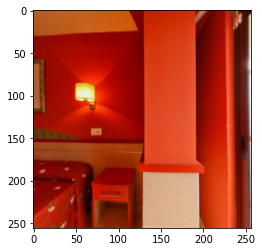

In [13]:
plt.imshow(cv2.cvtColor(pers, cv2.COLOR_BGR2RGB))

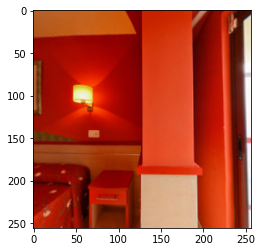

In [14]:
plt.imshow(cv2.cvtColor(target, cv2.COLOR_BGR2RGB))

# Feature matching to active vision

In [15]:
gray_pers = cv2.cvtColor(pers, cv2.COLOR_BGR2GRAY)
gray_target = cv2.cvtColor(target, cv2.COLOR_BGR2GRAY)

In [16]:
sift_detector = cv2.SIFT_create()

In [17]:
orb_detector = cv2.ORB_create()

In [18]:
(kps_pers, des_pers) = orb_detector.detectAndCompute(gray_pers, None)
(kps_target, des_target) = orb_detector.detectAndCompute(gray_target, None)

In [19]:
len(kps_pers)

155

In [20]:
len(kps_target)

149

In [21]:
kps_pers[0].pt

(56.0, 84.0)

In [22]:
kps = np.float32([kp.pt for kp in kps_pers])
# print(kps)

In [23]:
matcher = cv2.BFMatcher(normType=cv2.NORM_HAMMING, crossCheck=False)

In [24]:
# change normType for detector
raw_matches = matcher.knnMatch(des_pers, des_target, k=2)
matches = []
for m, n in raw_matches:
    if m.distance < 0.75 * n.distance:
        matches.append(m)

In [25]:
len(matches)

107

In [26]:
match_img = cv2.drawMatches(gray_pers, kps_pers, gray_target, kps_target, matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

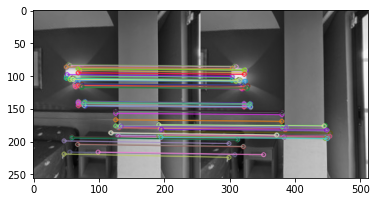

In [27]:
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))

In [28]:
# FIXME: are query and train, src and target?
pts_pers = np.float32([kps_pers[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
pts_target = np.float32([kps_target[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

In [29]:
M, mask = cv2.findHomography(pts_pers, pts_target, cv2.RANSAC, 5.0)

Homography matrix doesn't make sense...

In [30]:
M

array([[ 1.00129248e+00, -1.91355296e-02, -1.39719507e+00],
       [ 1.13982386e-02,  9.64923344e-01,  4.02628907e+00],
       [ 1.10835869e-04, -1.79736765e-04,  1.00000000e+00]])

In [31]:
actions = []

for m in matches:
    
    print(m.distance, m.queryIdx, m.trainIdx)
    if m.distance > 20:
        print(">>> far")
        continue
    
    # location in the perspective image
    print(kps_pers[m.queryIdx].pt)
    # locatin in the target image
    print(kps_target[m.trainIdx].pt)
    
    pers_loc = np.float32(kps_pers[m.queryIdx].pt)
    target_loc = np.float32(kps_target[m.trainIdx].pt)
    
    x_displacement = np.abs(pers_loc[0] - target_loc[0])
    y_displacement = np.abs(pers_loc[1] - target_loc[1])
        
    if 0 < x_displacement < 1 and 0 < y_displacement < 1:
        action = "stop"
    else:
        if x_displacement >= y_displacement:
            if pers_loc[0] > target_loc[0]:
                action = "right"
            elif pers_loc[0] < target_loc[0]:
                action = "left"
            else:
                print("this shouldn't occur...")
                action = "stop"
        elif x_displacement < y_displacement:
            if pers_loc[1] > target_loc[1]:
                action = "down"
            elif pers_loc[1] < target_loc[1]:
                action = "up"
            else:
                print("this shouldn't occur...")
                action = "stop"
        else:
            action = "stop"

    
    actions.append(action)

7.0 0 0
(56.0, 84.0)
(54.0, 86.0)
20.0 1 47
(51.0, 87.0)
(48.0, 88.80000305175781)
20.0 2 1
(70.0, 89.0)
(69.0, 92.0)
25.0 3 1
>>> far
9.0 5 3
(51.0, 100.0)
(48.0, 102.0)
23.0 6 6
>>> far
3.0 7 5
(51.0, 104.0)
(48.0, 106.0)
18.0 8 7
(62.0, 104.0)
(60.0, 106.0)
21.0 11 55
>>> far
18.0 12 9
(65.0, 106.0)
(62.0, 108.0)
21.0 13 11
>>> far
13.0 16 14
(69.0, 112.0)
(66.0, 114.0)
5.0 17 15
(65.0, 113.0)
(62.0, 115.0)
11.0 18 16
(74.0, 113.0)
(71.0, 115.0)
16.0 19 64
(67.0, 116.0)
(63.60000228881836, 120.00000762939453)
11.0 21 21
(69.0, 139.0)
(66.0, 142.0)
16.0 22 22
(79.0, 139.0)
(76.0, 142.0)
12.0 23 23
(69.0, 145.0)
(66.0, 148.0)
18.0 24 24
(79.0, 146.0)
(76.0, 148.0)
10.0 25 25
(126.0, 157.0)
(124.0, 159.0)
21.0 26 26
>>> far
12.0 27 27
(192.0, 175.0)
(189.0, 177.0)
21.0 28 29
>>> far
21.0 29 30
>>> far
11.0 30 31
(195.0, 181.0)
(193.0, 183.0)
9.0 31 32
(200.0, 185.0)
(198.0, 187.0)
12.0 34 34
(200.0, 190.0)
(197.0, 192.0)
18.0 35 35
(130.0, 191.0)
(127.0, 194.0)
7.0 36 36
(193.0, 192.0)

In [32]:
actions

['right',
 'right',
 'up',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'up',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'up',
 'right',
 'up',
 'right',
 'right',
 'right',
 'right',
 'up',
 'right',
 'up',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'up',
 'up',
 'up',
 'right',
 'right',
 'right',
 'up',
 'up',
 'right',
 'up',
 'up',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'up',
 'right',
 'up',
 'up',
 'right',
 'right',
 'right',
 'right',
 'up',
 'up',
 'right',
 'up',
 'right',
 'right',
 'up',
 'up',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'right',
 'up',
 'up',
 'up']

In [33]:
dst = cv2.warpPerspective(pers, M, (pers.shape[1], pers.shape[0]))

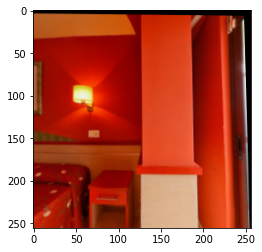

In [34]:
plt.imshow(cv2.cvtColor(dst, cv2.COLOR_BGR2RGB))